# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 8: Ensembles: Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

## Learning Objectives
Completing this assignment will demonstrate success at the following objectives:

- Statistical
  - Predict when bagging will help model performance.
  - Identify how Random Forests improve over bagging.
  - Predict when boosting will help model performance.
  - Compare and contrast bagging and boosting.
- Coding
  - Identify and fix problems in poorly written code
- Communication
  - Visually explain a complex concept

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<div class="theme"> Overview: Higgs Boson Discovery </div>

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('Higgs_train.csv')
data_test = pd.read_csv('Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

<div class="exercise"> <b> Question 1: A Single Model [20 pts]</b> </div>

We start by fitting a basic model we can compare the other models to. We'll pick a decision tree as the base model, because we'll later include random forests and want a fair comparison. We'll tune the decision tree using cross-validation. As usual, we'll be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.



**1.1**: Fit a decision tree model to the training set. Choose a range of tree depths to evaluate. Plot the estimated performance +/- 2 standard deviations for each depth using 5-fold cross validation. Also include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.

*Hint*: use `plt.fill_between` to shade the region.

**1.2** Select an appropriate depth and justify your choice. Using your cross-validation estimates, report the mean +/- 2 stdev. Then report the classification accuracy on the test set. (Store the training and test accuracies in variables to refer to in a later question.)

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? Your answer should refer to the bias-variance trade-off.

**Answers**

**1.1**

In [6]:
display(data_train['class'].value_counts(normalize=True))
display(data_test['class'].value_counts(normalize=True))

1.0    0.5246
0.0    0.4754
Name: class, dtype: float64

1.0    0.5296
0.0    0.4704
Name: class, dtype: float64

In [7]:
# your code here
depth = np.arange(1, 21, dtype=int)
train_acc = []
test_acc = []
cv_means = []
cv_std = []
dtrees = {}

for i in depth:
    dtrees[i] = DecisionTreeClassifier(max_depth=i).fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, dtrees[i].predict(X_train)))
    test_acc.append(accuracy_score(y_test, dtrees[i].predict(X_test)))
    cv = cross_val_score(dtrees[i], X_train, y_train, cv=5)
    cv_means.append(cv.mean())
    cv_std.append(cv.std())
cv_means = np.array(cv_means)
cv_std = np.array(cv_std)
train_acc = np.array(train_acc)
test_acc = np.array(test_acc)

Text(0.5,1,'Effect of Tree Depth on Accuracy')

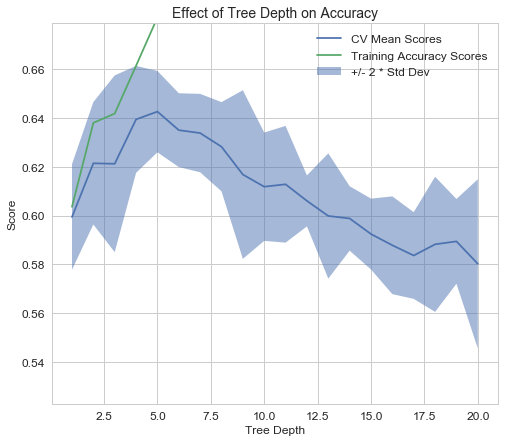

In [8]:
# your code here
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax.plot(depth, cv_means, label='CV Mean Scores')
ax.fill_between(depth, cv_means - 2*cv_std, cv_means + 2*cv_std, alpha=0.5, label='+/- 2 * Std Dev')
ax.plot(depth, train_acc, label='Training Accuracy Scores')
ax.set_ylim(top=(np.max(cv_means)+2*np.max(cv_std)))
ax.set_xlabel('Tree Depth', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.tick_params(labelsize=12)
ax.legend(loc='best', fontsize=12)
ax.set_title('Effect of Tree Depth on Accuracy', fontsize=14)

**1.2**

In [9]:
# your code here
print('The maximum mean CV score is %s which occurs at depth %s'%(cv_means[4],depth[4]))
print('with Standard Deviation: %s +/- 2 * %s'%(cv_means[4],cv_std[4]))

The maximum mean CV score is 0.6426041116041116 which occurs at depth 5
with Standard Deviation: 0.6426041116041116 +/- 2 * 0.008340632636921525


**Answer:**


We select CV mean accuracy score as our criteria for selecting the tree depth as  the training accuracy score will always increase as we keep increasing the depth. So based on the above plot, we can see that we get a maximum CV mean accuracy at $depth=5$ and then it starts to decrease after that. 

In [10]:
# your code here
print('Classification Accuracy on Test Set for Depth=5: %s' %test_acc[4])
print('Classification Accuracy on Train Set for Depth=5: %s' %train_acc[4])

Classification Accuracy on Test Set for Depth=5: 0.6478
Classification Accuracy on Train Set for Depth=5: 0.6812


**1.3**

**Answer:**

Using a greater tree depth and having training score as a criteria can get us a higher accuracy on the training data but will increasingly make our model over sensitive to the change in predictor values. Which make sense because with greater tree depths we model more points exactly the way they are in the training set and don't not allow for any uncertainty in our future data.  This will make our model highly biased to the observations in the training set thus making it less generalizable. So by limiting our tree depth, we purposely allow some unexplained variance in our training set (which is the downside to this approach) in order to allow for generalization of our model. This is also known as bias-variance-trade-off. This is acheived by limiting the tree depth to where we get the maximum cross-validation score.

<div class="exercise"> <b> Question 2: Bagging [25 pts]</b> </div>

Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.



**2.1** Choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth will overfit? Assign your choice to a variable here. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 45 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training (or test) example, each column is one of the trees, and each entry is that tree's prediction for that example. (Labeling the rows and columns is optional.)

Store these results as `bagging_train` and `bagging_test`. Don't worry about visualizing these results yet.

**2.3** _Aggregate_ all 45 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single depth-10 tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

**Answers**:

**2.1**

Text(0.5,1,'Effect of Tree Depth on Accuracy')

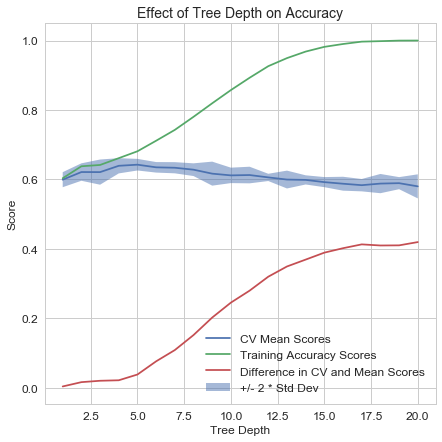

In [11]:
# your code here
diff = train_acc-cv_means
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(depth, cv_means, label='CV Mean Scores')
ax.fill_between(depth, cv_means - 2*cv_std, cv_means + 2*cv_std, alpha=0.5, label='+/- 2 * Std Dev')
ax.plot(depth, train_acc, label='Training Accuracy Scores')
ax.plot(depth, diff, label='Difference in CV and Mean Scores')
ax.set_xlabel('Tree Depth', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.tick_params(labelsize=12)
ax.legend(loc='best', fontsize=12)
ax.set_title('Effect of Tree Depth on Accuracy', fontsize=14)

**Answer:**

Recreating the plot from Q 1.1 with additionaly line for the difference in training and CV score. After $depth=5$ the mean CV score starts to go down and plateaus eventually while the training accuracy score shoots up. In particular, we see the difference in CV mean and train accuracy goes up at faster rate. Thus, any point after $depth=5$ will probably overfit the data to a certain degree. We purposely $depth=20$ and $R^2=1$ as it is far from $depth=5$ and the difference between the CV score and train accuracy score reaches its peak, so we can clearly see significant amount of difference in Test accuracy.

In [12]:
depth_overfit = 20

**2.2**

**Structure of `bagging_train` and `bagging_test`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


In [13]:
# your code here
bootpreds_train = {}
bootpreds_test = {}
boot_trees = {}
ntrees = 45
for i in range(ntrees):
    xboot, yboot = resample(X_train, y_train)
    boot_trees[i] = DecisionTreeClassifier(max_depth=depth_overfit).fit(xboot, yboot)
    bootpreds_train['bootstrap model %s prediction'%(i+1)] = boot_trees[i].predict(X_train)
    bootpreds_test['bootstrap model %s prediction'%(i+1)] = boot_trees[i].predict(X_test)

bagging_train = pd.DataFrame(bootpreds_train)
bagging_test = pd.DataFrame(bootpreds_test)
display(bagging_train.head(5))
display(bagging_test.head(5))   

,bootstrap model 1 prediction,bootstrap model 2 prediction,bootstrap model 3 prediction,bootstrap model 4 prediction,bootstrap model 5 prediction,bootstrap model 6 prediction,bootstrap model 7 prediction,bootstrap model 8 prediction,bootstrap model 9 prediction,bootstrap model 10 prediction,bootstrap model 11 prediction,bootstrap model 12 prediction,bootstrap model 13 prediction,bootstrap model 14 prediction,bootstrap model 15 prediction,bootstrap model 16 prediction,bootstrap model 17 prediction,bootstrap model 18 prediction,bootstrap model 19 prediction,bootstrap model 20 prediction,bootstrap model 21 prediction,bootstrap model 22 prediction,bootstrap model 23 prediction,bootstrap model 24 prediction,bootstrap model 25 prediction,bootstrap model 26 prediction,bootstrap model 27 prediction,bootstrap model 28 prediction,bootstrap model 29 prediction,bootstrap model 30 prediction,bootstrap model 31 prediction,bootstrap model 32 prediction,bootstrap model 33 prediction,bootstrap model 34 prediction,bootstrap model 35 prediction,bootstrap model 36 prediction,bootstrap model 37 prediction,bootstrap model 38 prediction,bootstrap model 39 prediction,bootstrap model 40 prediction,bootstrap model 41 prediction,bootstrap model 42 prediction,bootstrap model 43 prediction,bootstrap model 44 prediction,bootstrap model 45 prediction
0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,bootstrap model 1 prediction,bootstrap model 2 prediction,bootstrap model 3 prediction,bootstrap model 4 prediction,bootstrap model 5 prediction,bootstrap model 6 prediction,bootstrap model 7 prediction,bootstrap model 8 prediction,bootstrap model 9 prediction,bootstrap model 10 prediction,bootstrap model 11 prediction,bootstrap model 12 prediction,bootstrap model 13 prediction,bootstrap model 14 prediction,bootstrap model 15 prediction,bootstrap model 16 prediction,bootstrap model 17 prediction,bootstrap model 18 prediction,bootstrap model 19 prediction,bootstrap model 20 prediction,bootstrap model 21 prediction,bootstrap model 22 prediction,bootstrap model 23 prediction,bootstrap model 24 prediction,bootstrap model 25 prediction,bootstrap model 26 prediction,bootstrap model 27 prediction,bootstrap model 28 prediction,bootstrap model 29 prediction,bootstrap model 30 prediction,bootstrap model 31 prediction,bootstrap model 32 prediction,bootstrap model 33 prediction,bootstrap model 34 prediction,bootstrap model 35 prediction,bootstrap model 36 prediction,bootstrap model 37 prediction,bootstrap model 38 prediction,bootstrap model 39 prediction,bootstrap model 40 prediction,bootstrap model 41 prediction,bootstrap model 42 prediction,bootstrap model 43 prediction,bootstrap model 44 prediction,bootstrap model 45 prediction
0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


**2.3**

In [14]:
# your code here
bag_pred_train = np.sum(bagging_train, axis=1)>(ntrees/2)
bag_pred_test = np.sum(bagging_test, axis=1)>(ntrees/2) 

test_acc_bag = accuracy_score(y_test, bag_pred_test)
train_acc_bag = accuracy_score(y_train, bag_pred_train)
print('Accuracy of Bagged Model on Test Set: %s'%test_acc_bag)

Accuracy of Bagged Model on Test Set: 0.6914


In [15]:
assert test_acc_bag >= test_acc[4], "Accuracy too low"

**2.4**

In [16]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = {}
    for i in range(n_trees):
        running_correctnesss[i] = running_conclusions.iloc[:,i] == targets
    running_correctness = pd.DataFrame(running_correctnesss)
    
    return np.mean(running_correctness, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [17]:
# your code here
acc_train = running_predictions(bagging_train, y_train)
acc_test = running_predictions(bagging_test, y_test) 

Text(0.5,1,'Effect of Number of Trees on Accuracy')

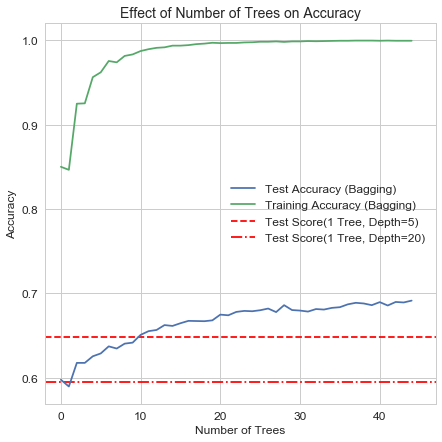

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.plot(acc_test, label='Test Accuracy (Bagging)')
ax.plot(acc_train, label='Training Accuracy (Bagging)')
ax.set_xlabel('Number of Trees', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlim(left=-2, right=ntrees+2)
ax.hlines(y=test_acc[4], xmin=-2, xmax=ntrees+2, color='red', linestyles='dashed',label='Test Score(1 Tree, Depth=5)')
ax.hlines(y=test_acc[19], xmin=-2, xmax=ntrees+2, color='red', linestyles='dashdot', label='Test Score(1 Tree, Depth=20)')
ax.tick_params(labelsize=12)
ax.legend(loc='center right', fontsize=12)
ax.set_title('Effect of Number of Trees on Accuracy', fontsize=14)

**2.5**

**Answer:**
The model for single tree of $Depth=20$ is actually exactly the same as `Bagging` where $ntrees=1$ since we are using $Depth=20$ for all trees in `Bagging`, so they both perform exactly same on the test set. However, single tree at $Depth=5$ (model we selected in Q.1.2) performs similar to `Bagging` when $ntrees=7$. This demonstrates the overfitting that occurs in the single tree model when depth is too high.

**2.6**

**Answer:**

As we can see in the above plot, increasing the number of trees does converge the training accuracy to 1, however, the test accuracy plateaus at just below 0.7. In contrast, if we look at the plot in 1.1, the test accuracy does go down considerably as we increase the depth.

In `Bagging`, we aggregate the results we get from all the individual models. So even if we use a tree depth that we know will overfit or underfit the data if we do a single tree, the final output of `Bagging` will not overfit the data depending on the number of trees we include in the process. Also, we can see that the tree at $Depth=5$ performs equally well as `Bagging` with $ntrees=7$ since we are using a depth that we know will overfit the data. Thus, if we use a depth that will create an overfit or underfit tree, we will need to fit more number of trees and do `Bagging` over all of them in order to get the best test performance versus if we use a depth that we know is optimal. 

**2.7**

**Answer:**

`Bagging` always uses the full set of predictors on each of the bootstrapped dataset, so most likely it will always choose the same set of predictors first, which explain most variance in the data. This means that when we average all the trees, we could treat some of the variables more important than they really are while others less. Thus, `Bagging` might be overfitting the data by using only a certain predictors that explain most variance as the partitioning criteria and may not capture some of the other predictors that explain variances that are not as strongly present in the training set but might show up in the test set.

<div class="exercise"> <b> Question 3: Random Forests [15 pts]</b> </div>

Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.



**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Evaluate its accuracy on the test set.

**3.2** For each of the decision trees you fit in the bagging process, how many times is each feature used at the top node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a table of the training and test accuracy for the following models:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 45 such trees (from Question 2)
- A Random Forest of 45 such trees (from Question 3.1)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

**Answers**:

**3.1**

In [19]:
# your code here
rf = RandomForestClassifier(n_estimators=45, max_depth=depth_overfit).fit(X_train, y_train)
rf_acc_train = accuracy_score(y_train, rf.predict(X_train))
rf_acc_test = accuracy_score(y_test, rf.predict(X_test))
print('Accuracy of Random Forest with Depth=20 on Train Set: %s' %rf_acc_train)
print('Accuracy of Random Forest with Depth=20 on Test Set: %s' %rf_acc_test)

Accuracy of Random Forest with Depth=20 on Train Set: 1.0
Accuracy of Random Forest with Depth=20 on Test Set: 0.6896


**3.2**

In [20]:
# your code here
top_bag = []
for i in boot_trees.keys():
    top_bag.append(boot_trees[i].tree_.feature[0])
    
var_bag, counts_bag = np.unique(top_bag, return_counts=True)
var_bag = data_train.columns[var_bag]
pd.DataFrame(counts_bag, var_bag)

,0
m_bb,45


In [21]:
top_rf = []
for i in rf.estimators_:
    top_rf.append(i.tree_.feature[0])

var_rf, counts_rf = np.unique(top_rf, return_counts=True)
var_rf = data_train.columns[var_rf]
pd.DataFrame(counts_rf, var_rf)

,0
lepton pT,1
lepton eta,2
lepton phi,1
missing energy magnitude,1
jet 1 pt,6
jet 2 phi,2
jet 4 b-tag,1
m_jj,1
m_jjj,4
m_jlv,2


**Answer:**

As we can see in the first table, the predictor `m_bb` was used at the top node in the `Bagging` model in all the 45 trees we fit, while from the second table we see that it was used at the top node in `Random Forest` only 12 times. In fact, there are also a lot more variables that were used at the top node other than `m_bb`. This is because, in `Bagging`, we bootstrap the data but fit the model using same set of predictors. So if there is one strong feature, it will be used as a top node almost every single time. However, for `Random Forest` we don't just bootstrap our data but we aslo randomly select a subset of predictors each time to fit the trees. This means that `Bagging` accuracy might be a little bit lower on the test set compared to te `Randfom Forest`.

**3.3**

Fill in the following table (ideally in code, but ok to fill in this Markdown cell).


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 45 depth-X trees | | |
| Random Forest of 45 depth-X trees | | |

In [22]:
# your code here
acc_table_dict = {
    'single tree with depth chosen by CV': np.array([train_acc[4], test_acc[4]]),
    'single depth-20 tree': np.array([train_acc[19], test_acc[19]]),
    'bagging 45 depth-20 trees': np.array([train_acc_bag, test_acc_bag]),
    'Random Forest of 45 depth-20 trees': np.array([rf_acc_train, rf_acc_test])
}

pd.DataFrame(acc_table_dict, index=['training accuracy', 'test accuracy']).T

,training accuracy,test accuracy
single tree with depth chosen by CV,0.6812,0.6478
single depth-20 tree,1.0000,0.5952
bagging 45 depth-20 trees,0.9994,0.6914
Random Forest of 45 depth-20 trees,1.0000,0.6896


**Answer:**

We can see that all the methods except `single tree with depth chosen by CV` reach a training accuracy of 1 or very close to 1. However, the test accuracy of `single tree with depth chosen by CV` is only third highest among all the models above - mainly because, even though the model is not overfitting, only one best tree is fit on the training set.

`single depth-20 tree` is clearly overfitting the training set as we can see the training accuracy is 1 while the test accuracy is just 0.6 which is the least among all models - as the model is trying to fit for very fine variances in the training data set. 

`bagging 45 depth-20 trees` and `Random Forest of 45 depth-20 trees`, even though they do show a training score of almost 1, have the highest test accuracy of all the models due to the aggregating of the predictions that happens only in these two models. That means that even if each of the individual trees in the process might overfit the training data (due to high depth), the overall predictions will be the averages of the results from all the trees.

<div class="exercise"> <b> Question 4: Boosting [15 pts]</b> </div>

In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more predictors to the ensemble.



**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

**4.2** The following code attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

**Answers**

**4.1**

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

In [23]:
# your code here
tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
tree1_pred = tree1.predict(X_train)
msk = tree1_pred == y_train
print(accuracy_score(y_train, tree1_pred))
print(accuracy_score(y_test, tree1.predict(X_test)))

0.6418
0.6442


Text(0.5,0.9,'Kernel Densities for Predictor Values in Decision Tree')

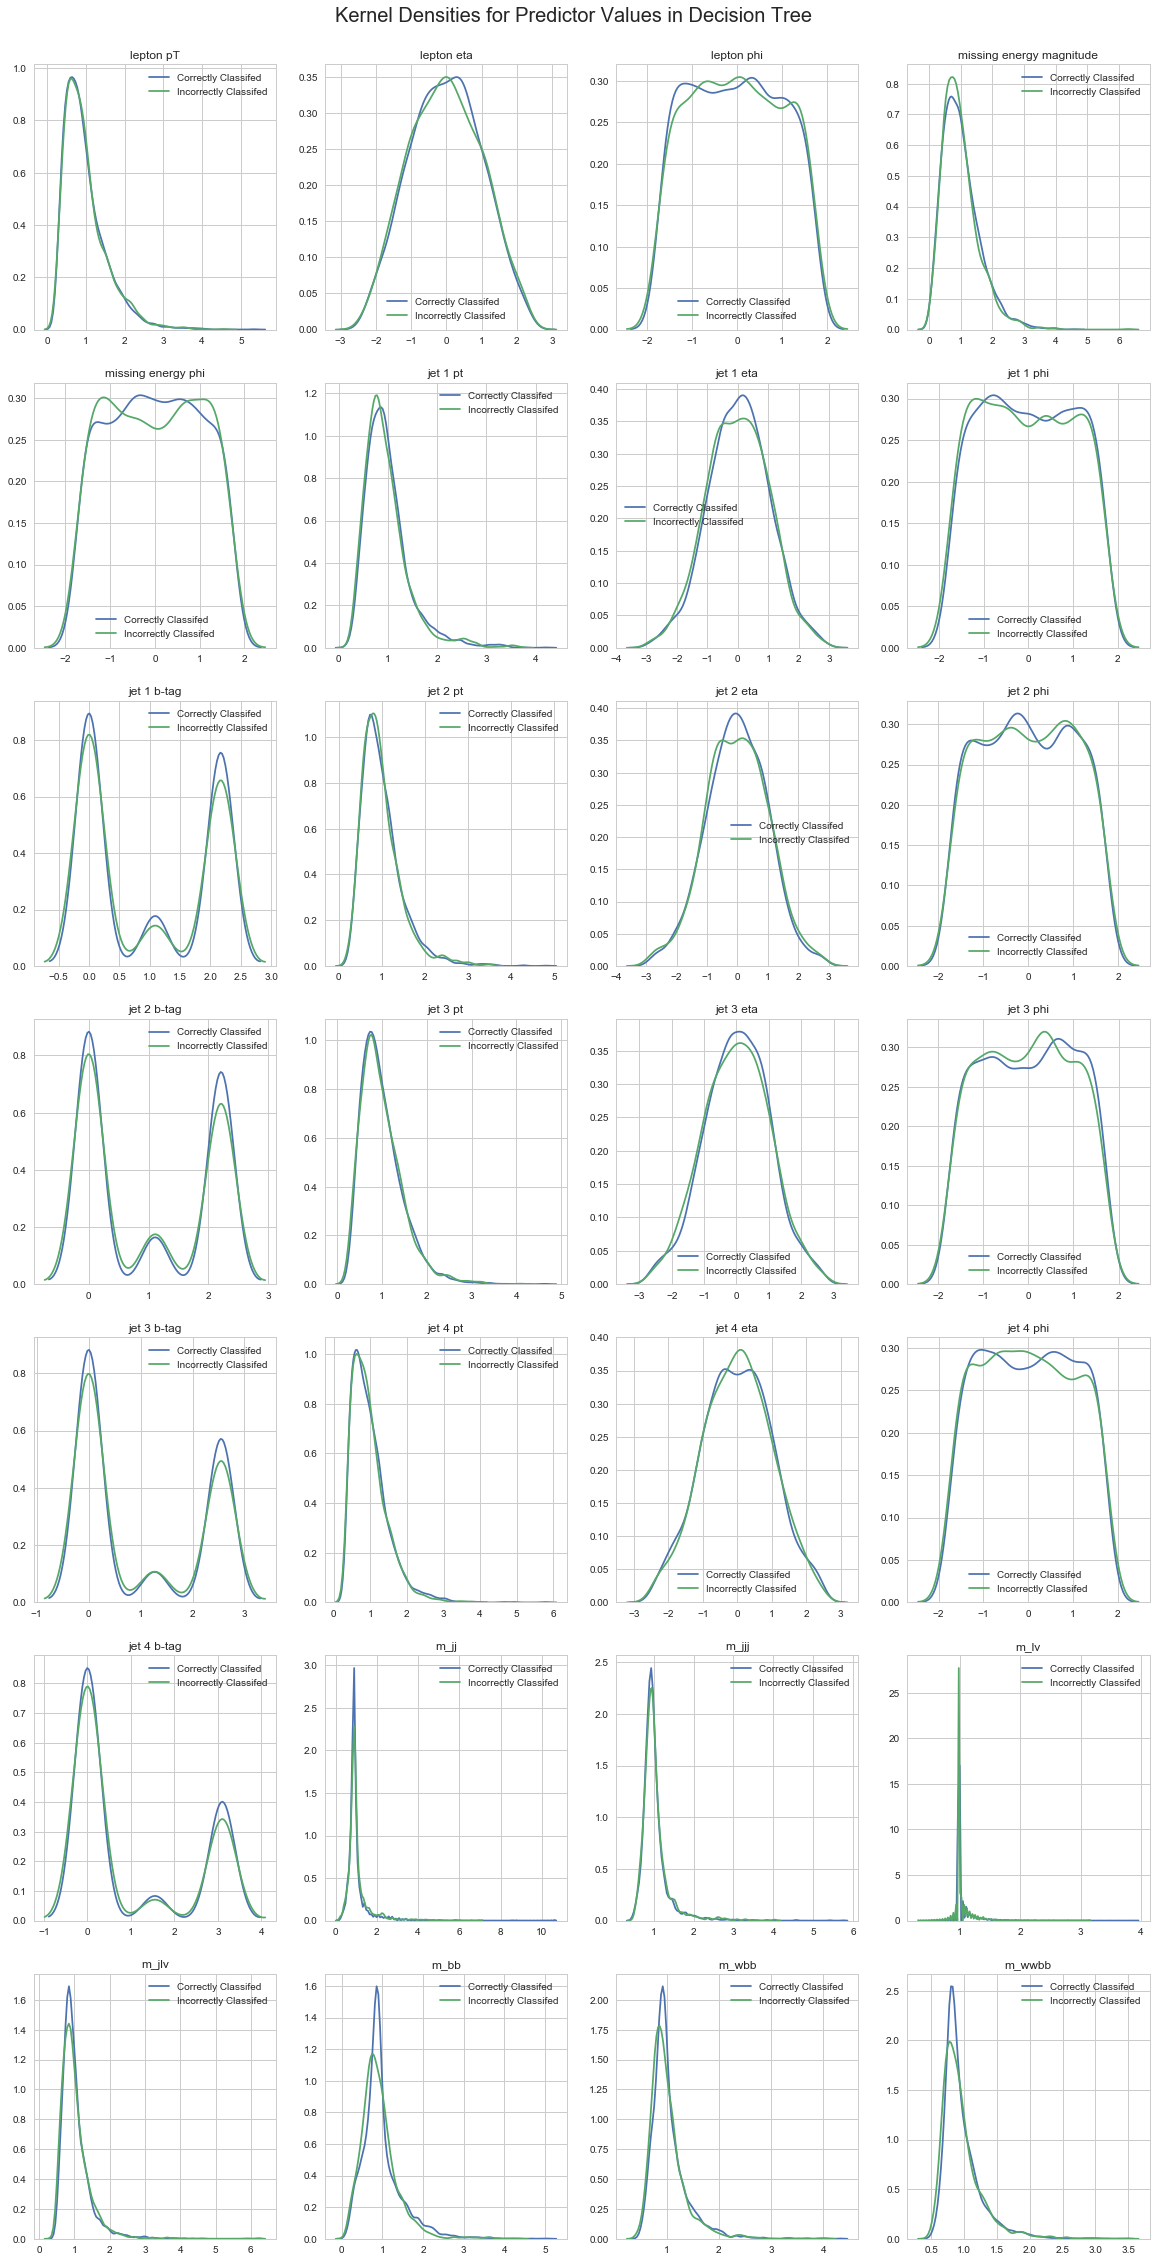

In [24]:
# your code here
fig, ax = plt.subplots(7, 4, figsize=(20,40))
i=0
j=0
k=0
for k in range(X_train.shape[1]):
    sns.kdeplot(X_train[msk, k], ax=ax[i,j], label='Correctly Classifed')
    sns.kdeplot(X_train[~msk,k], ax=ax[i,j], label='Incorrectly Classifed')
    title = data_train.columns[k]
    ax[i,j].set_title(title, fontsize=12)
    if k in [3,7,11,15,19,23]: 
        i=i+1
        j=0
    else:
        j=j+1
    k=k+1
fig.suptitle('Kernel Densities for Predictor Values in Decision Tree', y=0.90, fontsize=20)

**Answer:**

We can see that `m_jlv`, `m_bb` (highest difference), `m_wbb` and `m_wwbb` have similar means but the densities for 'Incorrectly Classified' are lower among these predictors than those for 'Correctly Classified' - showing that they are signicant. We can also see that `missing energy phi`, `jet 1 phi`, `jet 2 phi`,`jet 3 phi` and `jet 4 phi` show some deviance in their densities in the kde plots between correct and incorrect classifications, which means that there are ranges in these variables' values where the tree identifies the least classification error. Also, interesting to see that many of these have been selected as the top node in our `Random Forest` model in Question 3.2. Which demonstrates the fact that difference in the kde plots correspond to significance of the predictor.

**4.2**

The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [ ]:
def boostmeup():
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X_train, y_train)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
      if tree1.predict([X_train[idx]]) != y_train[idx]:
         sample_weight[idx] = sample_weight[idx] * 2
         q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup()

**Answer:**

1. One of the biggest value of writing a function lies in the ability to generalize it for operations that are required to be performed repeatedly - the above function does not take any input arguments and consequently loses the value of declaring it as a function instead of just a few lines of code.
2. You can include calculating the accuracy for train and test as one function in itself. 
3. Instead of printing out just the accuracy, may be output the predicted values of the boosted method, to give more flexibility to what we can do with the output.
4. Wrong indenting style used before the if statement in the first for loop.
5. Instead using for loop or if statement to compare the predicted values take advantage of vector operations using numpy arrays.
6. You can use .predict() function to predict the whole response column instead of using for loop.

In [25]:
# your code here
class boostmeup:
    def __init__(self, depth):
        self.depth = depth
        self.trees = {}
    
    def fit(self, X, y):
        tree = DecisionTreeClassifier(max_depth=self.depth)
        self.trees['1'] = tree.fit(X, y)
        tree1_pred = self.trees['1'].predict(X)
        sample_weights = np.ones(len(X))
        
        msk = tree1_pred == y
        sample_weights[msk] = sample_weights[msk] * 2
        self.trees['2'] = tree.fit(X, y, sample_weight=sample_weights)
        return(self.trees)

    def predict(self, trees_fit, X_pred):
        t1p = trees_fit['1'].predict_proba(X_pred)
        t1p_df = pd.DataFrame(t1p).iloc[:,1]
        t2p = trees_fit['2'].predict_proba(X_pred)
        t2p_df = pd.DataFrame(t2p).iloc[:,1]
        m = ((t1p_df + t2p_df)/2)>0.5
        return(m)
    
trees = boostmeup(depth=3).fit(X=X_train, y=y_train)
boost_pred_train = boostmeup(depth=3).predict(trees_fit = trees, X_pred=X_train)
boost_pred_test = boostmeup(depth=3).predict(trees_fit = trees, X_pred=X_test)

print('Train Accuracy of Manual Boosting: %s' %accuracy_score(y_train, boost_pred_train))
print('Test Accuracy of Manual Boosting: %s' %accuracy_score(y_test, boost_pred_test))

Train Accuracy of Manual Boosting: 0.6418
Test Accuracy of Manual Boosting: 0.6442


We see that our simple boosted model gets the same accuracy as the original single tree model in Q. 4.1.

**4.3**

In [27]:
# your code here
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=800, learning_rate=0.05)
ada_model = AdaBoost.fit(X_train, y_train)
stg_score_train = list(ada_model.staged_score(X_train, y_train))
stg_score_test = list(ada_model.staged_score(X_test, y_test))

In [28]:
acc_ada_train = accuracy_score(y_train, ada_model.predict(X_train))
acc_ada_test = accuracy_score(y_test, ada_model.predict(X_test))

print('AdaBoost Accuracy on Train Set: %s'%acc_ada_train)
print('AdaBoost Accuracy on Test Set: %s'%acc_ada_test)

AdaBoost Accuracy on Train Set: 0.9026
AdaBoost Accuracy on Test Set: 0.665


Text(0.5,1,'Staged Accuracy as a Function of Iterations')

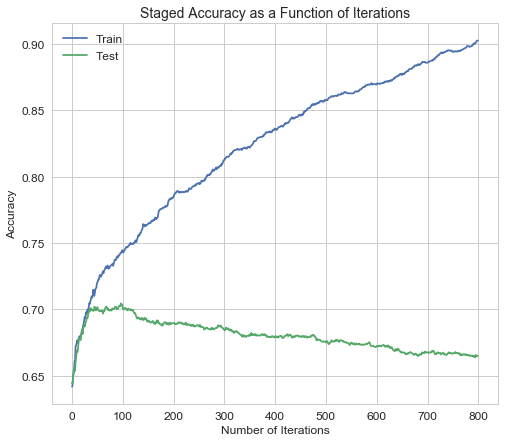

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,7))
ax.plot(stg_score_train, label='Train')
ax.plot(stg_score_test, label='Test')
ax.set_xlabel('Number of Iterations', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.tick_params(labelsize=12)
ax.legend(loc='best', fontsize=12)
ax.set_title('Staged Accuracy as a Function of Iterations', fontsize=14)

**4.4**

In [30]:
ada_models = {}
stgscores_train = {}
stgscores_test = {}
for i in range(1, 5):
    AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i), n_estimators=800, learning_rate=0.05)
    ada_models[i] = AdaBoost.fit(X_train, y_train)
    stgscores_train[i] = list(ada_models[i].staged_score(X_train, y_train))
    stgscores_test[i] = list(ada_models[i].staged_score(X_test, y_test))

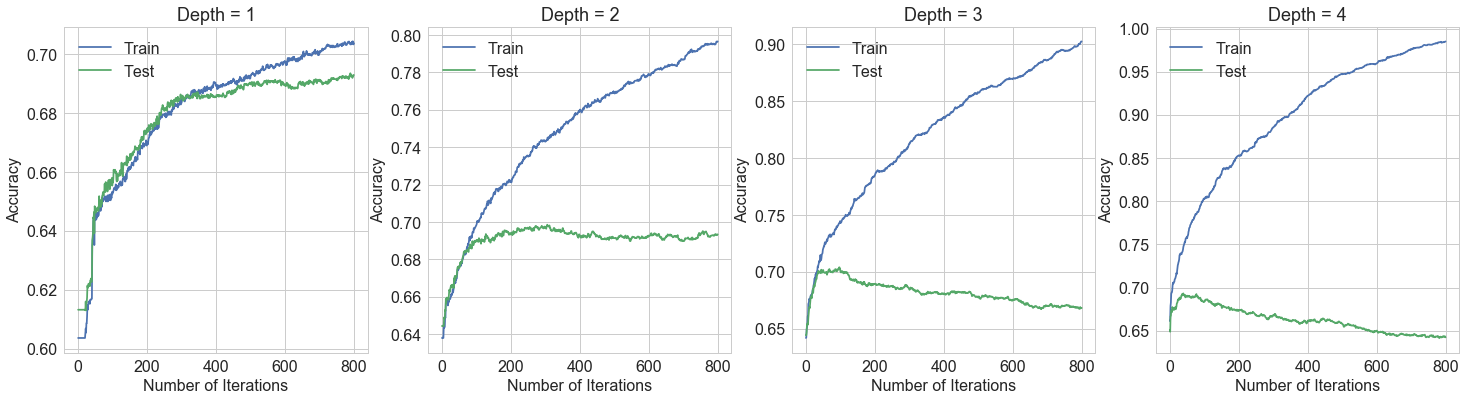

In [31]:
# your code here
fig, ax = plt.subplots(1,4, figsize=(25,6))
for i in range(1, 5):
    ax[i-1].plot(stgscores_train[i], label='Train')
    ax[i-1].plot(stgscores_test[i], label='Test')
    ax[i-1].set_xlabel('Number of Iterations', fontsize=16)
    ax[i-1].set_ylabel('Accuracy', fontsize=16)
    ax[i-1].tick_params(labelsize=16)
    ax[i-1].legend(loc='best', fontsize=16)
    ax[i-1].set_title('Depth = %s'%i, fontsize=18)    

**Answer:**

With $Depth=1$, both train and test accuracies are more or less the same at given number of iterations going from 0 to 800, however, we see this change as we increase the depth. In short, the model starts to overfit on the training data with increase in the number of iterations as well as depth of the trees.

**4.5**

In [32]:
# your code here
print('Test Set Accuracy Depth=3, Iterations=105: %s'%stgscores_test[3][104])
print('Training Set Accuracy Depth=3, Iterations=105: %s'%stgscores_train[3][104])

Test Set Accuracy Depth=3, Iterations=105: 0.7006
Training Set Accuracy Depth=3, Iterations=105: 0.7452


**Answer:**

As we can see, $Depth=3$ and $Iterations=105$ gives us the optimum accuracy as the test score is highest at this point. Thus, our model has the optimum bias-variance-trade-off at this point. The above model has the highest test accuracy among all the other ensemble models we considered so far. That is because we are optimizing the model with each iteration at a chosen learning rate during the `Boosting` process, whereas the other methods just aggregate all the models together at the end. Thus in boosting we get to take small steps toward the optimal solution.

<div class="exercise"> <b> Question 5: Understanding [15 pts]</b> </div>

This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.



**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?

**Answers**:

**5.1**

**Answer:**

*Similarities:*
1. `Boosting` and `Bagging` are both ensemble methods of finding the best possible model by fitting a large number of models and then aggregating from the results from each one of them. 
2. They both use the entire set of available predictors for each tree fit.

*Differences:*
1. In `Bagging`, the results from all the individual models are aggregated to get the final output. In `Boosting`, we only model for the mistakes in the previous model and add a fraction (desired learning rate) of it to the previous model. 
2. As a result of the first point, in `Bagging`, we distribute the error over all the trees that are fit during the process in one single step. In `Boosting`, we only try to reduce the error by a certain amount that is a fraction of the total error (learning rate) with each step and leave the rest for the future models.
3. `Bagging` is not iterative and can be computationally parallelized. `Boosting` is iterative and cannot be parallelized.
4. All samples are given the same weights in all the trees in `Bagging`. The samples that are incorrectly predicted are given greater weights or sometimes those are the only sample that are considered in `Boosting` after the first step.
5. The data is `bootstrapped` only in `Bagging` but not in `Boosting`.

**5.2**

**Answer:**

A single `Decision Tree` will always be more prone to overfitting or underfitting since we are required to choose the hyperparameters manually. It also doesn't account for any variability in the sample observations and thus yeids least accuracy among all the other tree based models for a given depth. `Bagging` is an improvement over a single tree where we fit a number of trees on the bootstrapped data using the entire subset of predictors and `Random Forest` is an improvement over `Bagging`, where we create a 'forest' by fitting large number of trees using bootstrappeed data and a random subset of j predictors (where $j<p$). They both perform better than a single tree, with `Random Forest` sometimes better than `Bagging` in cases where we have multi-collinearity in the predictor set. The `Boosting` model for selected values of hyperparameters performs the best, as we also do optimization during the model fitting process and take small steps in each step thereby reducing the chances of skipping over the optimal solution.

**5.3**

**Answer:**

We overfit the data in both the methods with the addition of too many trees, `Bagging` and `Boosting`. `Bagging` has more impact if we have too many trees as opposed to `Boosting` as `Bagging` will fit all the trees independently and take an aggregate of all the models all at the end in one single step. However, in `Boosting`, that effect is controlled by the learning rate we choose and with the addition of each tree we get to see the error rate and detereming where our optimal solution lies. Thus, it is worse to have to many trees in case of `Bagging`.

**5.4**

**Answer:**

Since each tree in the `Bagging` process is fit independently of any other trees, it doesn't need to be performed in a specific order. `Boosting`, however, is a iterative process and needs information from the last step to perform consequent step. Thus, parallelization is better suited for `Bagging` compared to `Boosting`.

**5.5**

**Answer:**

All of the techniques in this assignment can be extended to regression by using the `RSS` or `MSE` as the criterion at each node while partitioning and creating regions, instead of the classification error metric (different for different models). While predicting the output, we give out the average of the response in that region in which the particular observation falls based on the predictor values.

<div class="exercise"> <b> Question 6: Explaining Complex Concepts Clearly [10 pts]</b> </div>

One of the core skills of a data scientist is to be able to explain complex concepts clearly. To practice this skill, you'll make a short presentation of one of the approaches we have recently studied.

**Choose one of the following topics:**

- Decision Trees
- Random Forests
- Bagging
- Boosting
- Simple Neural Nets (like the MLP we saw in Homework 6)
- (other topics are possible, but get staff approval first)

**Make 3 slides explaining the concept.**

- Focus on **clear explanations**, NOT aesthetic beauty. Photos of pen-and-paper sketches are fine if they're legible.
- For your audience, choose **future CS109A students**.
- You may take inspiration from anywhere, but explain in **your own words** and **make your own illustrations**.


Submit your slides as a PDF and the source format (`.pptx`, Google Slides, etc.)

NOTE: If you would be okay with us using your slides for future classes (with attribution, of course), please include a note to that effect. This will not affect your grade either way.